#Theoretical model for a mixture of charged colloids, with counterions and salt and a polymer depletant

###Required imports

---

In [1]:
import os
import csv
import pandas as pd
import numdifftools as nd
from math import pi, exp, sqrt, log
from numpy.linalg import det, slogdet
from numpy import array
import matplotlib.pyplot as plt
import collections
import functools
%matplotlib inline 

###Create a memoized class to decorate some functions with and prevent trivial re-evaluation

---

In [2]:
class memoized(object):
    '''Decorator. Caches a function's return value each time it is called.
    If called later with the same arguments, the cached value is returned
    (not reevaluated).
    '''
    def __init__(self, func):
        self.func = func
        self.cache = {}
    def __call__(self, *args):
        if not isinstance(args, collections.Hashable):
            # uncacheable. a list, for instance.
            # better to not cache than blow up.
            return self.func(*args)
        if args in self.cache:
            return self.cache[args]
        else:
            value = self.func(*args)
            self.cache[args] = value
            return value
    def __repr__(self):
        '''Return the function's docstring.'''
        return self.func.__doc__
    def __get__(self, obj, objtype):
        '''Support instance methods.'''
        return functools.partial(self.__call__, obj)

###Function to make the hard sphere RDF dictionary
This reads in all of the hard sphere g(r) csv files in "\data\hs_structure\" of the working directory and places each (in order of increasing volumne fraction) into a pandas dataframe. There is also an "r" column that correpsonds to the radial distance and appears at the very end of the dataframe

**NOTE**: the RDF files must start at zero volume fraction and increase in one fixed increment (automatically detected when read in)

---

In [3]:
#read each rdf file at each volume fraction and store in a dictionary within a dictionary
#with volume fraction as the first key and r as the second key for very rapid read
def load_hs_rdf_data(rdf_directory):    
    rdf_files = os.listdir(rdf_directory) 
    
    rdf_file = rdf_files[0] #extract first filename
    eta = rdf_file[-11:-4] #extract the volume fraction from filename
    rdf_data = pd.read_csv(filepath_or_buffer = rdf_directory + rdf_file, header = None, names = ["r", float(eta)]) 
    
    for rdf_file in rdf_files[1:]: #loop over the various files in the rdf_data folder
        eta = rdf_file[-11:-4]
        rdf_data_2 = pd.read_csv(filepath_or_buffer = rdf_directory + rdf_file, header = None, names = ["r", float(eta)])[float(eta)]
        rdf_data = pd.concat([rdf_data, rdf_data_2], axis=1)   
    
    rdf_data = rdf_data.reindex_axis(sorted(rdf_data.columns), axis=1) #make sure columns go in ascending order of volume fraction
        
    return rdf_data

###Function to create an RDF at a specified volume fraction
This works by linearly interpolating between the two nearest stored volume fractions.

---

In [4]:
#takes as input the desired volume fraction and the gr data in dataframe format
#and linearly interpolates between the two nearest stored volume fractions
@memoized
def calculate_rdf(eta, d):
    rdf = pd.DataFrame()
    
    eta_inc = rdf_data.columns[1] #store the eta increment
    eta_max = rdf_data.columns[-2] #store the maximum eta to check if overstepped
    upper_index = int(eta / eta_inc) + 1 #for storing the nearest low and high volume fractions
    lower_index = int(eta / eta_inc)
    
    if eta >= eta_max:
        print "error: eta is too large to calculate!"
        return rdf
    try:
        eta_upper = rdf_data.columns[upper_index] #grab the lower and upper packing fractions for interpolation
        eta_lower = rdf_data.columns[lower_index]
    except:
        print "error: something went wrong with rdf calculation!"
        return rdf
    
    #create the interpolated rdf
    rdf["gr"] = ((eta_upper - eta)/(eta_upper - eta_lower))*rdf_data[eta_lower] + ((eta - eta_lower)/(eta_upper - eta_lower))*rdf_data[eta_upper]
    rdf["r"] = d*rdf_data["r"]
    return rdf

###Load RDF data into memory
The loaded RDF data will be used as a **global** variable to avoid having to copy things around from one function to another. All RDF's are normalized to use a core diameter of unit length which is then easily converted (by rescaling r) to another of different size when generating the desired interpolated RDF.

---

**Global structure variable**

In [5]:
rdf_data = load_hs_rdf_data("data/hs_structure/")

Example calculation of an RDF follows as:

In [6]:
rdf = calculate_rdf(0.332, 6.0)
if not rdf.empty:
    print rdf.head()

         gr     r
0  2.741410  6.00
1  2.697945  6.03
2  2.655185  6.06
3  2.613303  6.09
4  2.572280  6.12


In [7]:
rdf = calculate_rdf(0.61, 2.0)
if not rdf.empty:
    print rdf.head()

error: eta is too large to calculate!


###Calculates ideal free energy contribution
This is comprised of the large colloids (or polyions), the polymer and the two monovalent ions. The form I use below is technically incorrect as the density has dimensions and I apply a log to it. This is irrelevant though as any arbitrary constant volume multiplicative factor can be introduced in the log without penalty. Upon taking a derivative with repect to density, one would find this term cancels itself. This is the same as saying the free energy is totally arbitrary to within a constant additive factor

---

In [8]:
def calculate_f_id(p_c, p_p, p_pos, p_neg, d_c, d_p):
    
    #just creating an arbitrary length scale to non-dimensionalize the log term
    vol = (d_c/2.0 + d_p/2.0)**3.0
    p = p_c + p_p + p_pos + p_neg
    
    #ideal contribution containing both mixing and translational entropy
    fid = p_c*log(p_c*vol) + p_p*log(p_p*vol) + p_pos*log(p_pos*vol) + p_neg*log(p_neg*vol) - p
    
    return fid

###Calculates perturbative polyion-polyion DLVO free energy contribution
I use an approximation due to Hamad which says the non-additive RDF contact values can be determined from a purely hard sphere contact value at a rescaled volume fraction. I go beyond this and extend this argument to say the whole RDF can be approximated as this is needed for the repulsive DLVO pair contribution to the free energy.

---

In [9]:
def cc_perturb_integral(p_c, #state variables (removed p_p)
                        n_c, k, #redundant state variables already calculated in calling function
                        l, Z_c, d_c, d_p #system parameters
                        ):
    
    #effective charge parameter to be used in calculating the DLVO colloid-colloid pair interaction
    Z_eff = Z_c*(exp(k*(d_c/2.0))/(1.0 + k*(d_c/2.0)))
    
    #calculate the AO rdf according to Hamad with extension to the whole RDF (Hamad only used for contact value)
    #w_cc = calculate_n_scale("cc", p_c, p_p, d_c, d_p)
    #rdf = calculate_rdf(w_cc*n_c, d_c)
    rdf = calculate_rdf(n_c, d_c)
    
    #calculate the integral
    #the rdf only contains data outside the core region
    dr = rdf["r"][1] - rdf["r"][0]
    integral = 0.0
    for index in rdf.index.values[:-1]:
        r_1 = rdf["r"][index]
        r_2 = rdf["r"][index + 1]
        gr_1 = rdf["gr"][index]
        gr_2 = rdf["gr"][index + 1]
        Bur_1 = (Z_eff**2.0)*l*(exp(-k*r_1)/r_1)
        Bur_2 = (Z_eff**2.0)*l*(exp(-k*r_2)/r_2)
        fr_1 = exp(-Bur_1) - 1.0
        fr_2 = exp(-Bur_2) - 1.0
        integral = integral + (1.0/2.0)*dr*((r_1**2.0)*gr_1*fr_1 + (r_2**2.0)*gr_2*fr_2)
        
    return integral

#############################################################################################

@memoized
def calculate_f_ex_dlvo(p_c, p_pos, p_neg, #state variables
                        l, Z_c, d_c, d_p #system parameters
                        ):
    
    #calculate various other parameters that make the below expression a little cleaner
    #ion variables
    p_ions = p_pos + p_neg
    s = (2.0*p_pos*p_neg)/p_ions
    k = sqrt(4.0*pi*l*p_ions)
    #colloid variables
    n_c = (pi/6.0)*(d_c**3.0)*p_c
        
    #breaking up the various contributions for simplicity
    f_ex_dlvo_ion_coord = -(p_c*(Z_c**2.0)*(l/d_c))*((k*(d_c/2.0))/(1.0 + k*(d_c/2.0)))
    f_ex_dlvo_exc_vol = (n_c*s)/(1.0-n_c)
    f_ex_dlvo_neg_mean_field = -(1.0/2.0)*((4.0*pi*l*((p_c*Z_c)**2.0))/(k**2.0))
    f_ex_dlvo_pair_perturb = -2.0*pi*(p_c**2.0)*cc_perturb_integral(p_c, n_c, k, l, Z_c, d_c, d_p)
    
    #total DLVO contribution to the free energy
    f_ex_dlvo = f_ex_dlvo_ion_coord + f_ex_dlvo_exc_vol + f_ex_dlvo_neg_mean_field + f_ex_dlvo_pair_perturb
    
    return f_ex_dlvo

###Calculates the perturbative polyion-polymer adsorption free energy contribution
This uses a perturbative inclusion of short range attractions between the polyions and polymers. These attractions can be throught of as including both VDW and dipole-ion interactions

---

In [10]:
def calculate_f_ex_int(p_c, p_p, #state variables
                        d_c, d_p, R_cp, BA, #system parameters
                        ):
    
    #transform to some helpful variables
    n_c = (pi/6.0)*(d_c**3.0)*p_c
    
    #calculate the AO rdf according to Hamad with extension to the whole RDF (Hamad only used for contact value)
    #w_cp = calculate_n_scale("cp", p_c, p_p, d_c, d_p)
    #g_contact = calculate_rdf(w_cp*n_c, (d_c/2.0 + d_p/2.0))["gr"][0]
    g_contact = 1.0/(1.0 - n_c)
    
    #interfacial free energy contribution
    f_ex_int = -4.0*pi*p_c*p_p*R_cp*((d_c/2.0 + d_p/2.0)**2.0)*g_contact*(exp(BA)-1.0)
    
    return f_ex_int

###Calculates the excess contribution of the non-addittive AO model to the free energy
This uses the approximate equation of state of Woodward et al. I use this as apposed to the Santos theory as it is simpler and yields similar results to the free volume form which agrees well with Santos.

---

In [11]:
def calculate_f_ex_ao(p_c, p_p, #state variables
                      d_c, d_p #system parameters
                      ):
    
    #calculate volume fraction
    n_c = (pi/6.0)*(d_c**3.0)*p_c
    
    #ratio
    q = d_p/d_c
    
    #some parameters
    A = 3.0*q + 3.0*(q**2.0) + q**3.0
    B = (9.0/2.0)*(q**2.0) + 3.0*(q**3.0)
    C = 3.0*(q**3.0)
    w = -log(1.0 - n_c) + A*(n_c/(1.0 - n_c)) + B*((n_c/(1.0 - n_c))**2.0) + C*((n_c/(1.0 - n_c))**3.0)
    
    #free volume theory free energy
    f_ex_hs_ref = p_c*(-3.0 + 2.0/(1.0 - n_c) + 1.0/((1.0 - n_c)**2.0)) 
    f_ex_fv_pert = p_p*w
    
    #total free energy
    f_ex_ao = f_ex_hs_ref + f_ex_fv_pert
    
    return f_ex_ao   

###Calculates the total free energy of the colloid-polymer-ion system
This just calls the four separate free energy functions and adds them all up. 

Up to this point I have treated the colloid and ions all as separate entities. Formally this is fine but electroneutrality ultimately sets a linear constraint on what combinations of the three charges species are possible. For this I first assume that the charge on the colloid is positive (as it is in the experimental system) which means the density of positive ions is the density of the added salt in this simple system. Thus, when performing phase coexistence calculations the phases can be expressed as the amount of colloid, polymer and extra salt.

---

In [12]:
def calculate_f_explicit_ions(p_c, p_p, p_pos, p_neg, #state variables
               d_c, d_p, #particle sizes
               l, Z_c, #ionic solution parameters
               R_cp, BA #interfacial attraction parameters
               ):
    
    #ideal
    f_id = calculate_f_id(p_c, p_p, p_pos, p_neg, d_c, d_p)
    #excess dlvo
    f_ex_dlvo = calculate_f_ex_dlvo(p_c, p_pos, p_neg, l, Z_c, d_c, d_p) 
    #excess c-p interfacial
    f_ex_int = calculate_f_ex_int(p_c, p_p, d_c, d_p, R_cp, BA)
    #excess ao
    f_ex_ao = calculate_f_ex_ao(p_c, p_p, d_c, d_p)
    #the whole thing
    f = f_id + f_ex_dlvo + f_ex_int + f_ex_ao
    
    return f

This is an alternative form that expresses the free energy in terms of densities alone by simply referencing the other form--this makes the stability calculation easier to work with.

In [13]:
def calculate_f(p_c, p_p, p_s, #state variables
               d_c, d_p, #particle sizes
               l, Z_c, #ionic solution parameters
               R_cp, BA, #interfacial attraction parameters
               ):
    
    #calculate the various densities based on specifying the salt density and the colloid and polymer
    if Z_c > 0.0:
        p_pos = p_s
        p_neg = p_pos + Z_c*p_c #charge neutrality condition
    else:
        p_neg = p_s
        p_pos = p_neg - Z_c*p_c #charge neutrality condition
    
    #sum up the contributions
    f = calculate_f_explicit_ions(p_c, p_p, p_pos, p_neg, d_c, d_p, l, Z_c, R_cp, BA)

    return (f, f/(p_c + p_p + p_neg + p_pos))

###Function for calculating the stability matrix and its determinant
This calculates the determinant of the 3x3 stability matrix for use in finding homogenous phase spinodal limits. The matrix is only 3x3 despite the 4 components due to charge neutrality. The particular choice I make for the matrix is the 3x3 of chemical potential derivatives with respect to the colloid, polymer and salt particle numbers. Also, the **free energy is per V** (not N) as this simplifies the matrix elements.

---

In [14]:
def calculate_stability_determinant(p_c, p_p, p_s, #state variables
                                    d_c, d_p, #particle sizes
                                    l, Z_c, #ionic solution parameters 
                                    R_cp, BA, #interfacial attraction parameters
                                    min_step #minimum step to use for hessian calculation
                                   ):
    
    #calculate the hessian matrix
    hess_steps = nd.MinStepGenerator(base_step=min_step, step_ratio=2.0, num_steps = 2)
    calculate_hessian = lambda x: calculate_f(x[0], x[1], x[2], d_c, d_p, l, Z_c, R_cp, BA)[0]
    stability_matrix = nd.Hessian(calculate_hessian, step = hess_steps)([p_c, p_p, p_s])
    
    #build the 3x3 stability matrix as a numpy array and calculate the determinant 
    #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
    (sign, logdet) = slogdet(stability_matrix)
    stability_determinant = sign*exp(logdet)    
        
    #return the stability determinant
    return (stability_matrix, stability_determinant)

**Test to see if stability calculation is even working**

In [15]:
d_c = 1.0 #1.0
d_p = 0.3 #0.3
R_cp = 0.01 #0.05
l = 1.0
Z_c = 1.0
BA = 0.00000001

#colloid and polymer
n_c = 0.025
p_c = 6.0*n_c/(pi*d_c*d_c*d_c)

#salt
p_s = 0.1*p_c

n_p_inc = 0.1
n_p_min = 1.0 #2.1
n_p_max = 3.0 #2.5
n_p_data_2 = []
#det_data_2 = []
#det_data_3 = []
det_data_4 = []
min_step= 0.001 #0.001
for k in range(int(n_p_min/n_p_inc) - 1, int(n_p_max/n_p_inc) + 1):
    n_p = n_p_inc*k
    p_p = 6.0*n_p/(pi*d_p*d_p*d_p)
    
    print p_c
    print p_p
    
    determinant = calculate_stability_determinant(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, min_step)
    #determinant2 = calculate_stability_determinant_ao_pure(p_c, p_p, d_c, d_p, min_step)

    
    print n_p
    print determinant
    n_p_data_2.append(n_p)
    #det_data_2.append(determinant[1])
    #det_data_3.append(determinant[1])
    det_data_4.append(determinant[1])


0.0477464829276
63.6619772368
0.9
(array([[  1.24883496e+02,   1.21014058e+00,   1.92231477e+01],
       [  1.21014058e+00,   1.57079742e-02,   0.00000000e+00],
       [  1.92231477e+01,   0.00000000e+00,   2.24549742e+02]]), 105.84752744841289)
0.0477464829276
70.7355302631
1.0
(array([[  1.34149958e+02,   1.21014056e+00,   1.92231477e+01],
       [  1.21014056e+00,   1.41371643e-02,  -9.47390314e-09],
       [  1.92231477e+01,  -9.47390314e-09,   2.24549742e+02]]), 91.794820856703595)
0.0477464829276
77.8090832894
1.1
(array([[  1.43416419e+02,   1.21014056e+00,   1.92231477e+01],
       [  1.21014056e+00,   1.28519719e-02,   0.00000000e+00],
       [  1.92231477e+01,   0.00000000e+00,   2.24549742e+02]]), 80.29759813141996)
0.0477464829276
84.8826363157
1.2
(array([[  1.52682881e+02,   1.21014058e+00,   1.92231477e+01],
       [  1.21014058e+00,   1.17809869e-02,   1.18423789e-09],
       [  1.92231477e+01,   1.18423789e-09,   2.24549742e+02]]), 70.716880608956586)
0.0477464829276
9

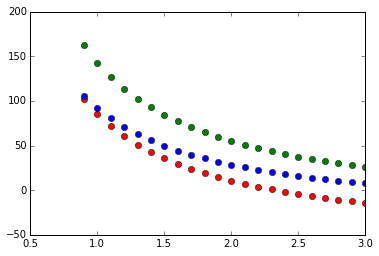

In [157]:
#plt.plot(n_p_data, det_data, 'ro')
plt.plot(n_p_data_2, det_data_2, 'ro')
plt.plot(n_p_data_2, det_data_3, 'go')
plt.plot(n_p_data_2, det_data_4, 'bo')
#plt.plot(0.04954419342053111, 0, 'o')
#plt.ylim((-60,60))
#plt.xlim((0.043,0.045))

In [16]:
def calculate_spinodal(p_c_low, p_c_hi, p_c_inc, p_p_low, p_p_hi, p_p_inc, #state variables for grid search
                    p_s, #state variables held fixed
                    d_c, d_p, #particle sizes
                    l, Z_c, #ionic solution parameters 
                    R_cp, BA, #interfacial attraction parameters
                    min_step #minimum step to use for hessian calculation
                    ):
    
    #lists for storing the grid points classified as stable and unstable 
    stable = [[],[]]
    unstable = [[],[]]
    
    #sample the grid points
    p_c = p_c_low
    while p_c < p_c_hi:
        p_p = p_p_low
        while p_p < p_p_hi:
            determinant = calculate_stability_determinant(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, min_step)[1]
            if determinant < 0.0:
                unstable[0].append(p_c)
                unstable[1].append(p_p)
            else:
                stable[0].append(p_c)
                stable[1].append(p_p)
            p_p = p_p + p_p_inc
            #print p_p
        p_c = p_c + p_c_inc
        #print p_c
    
    return (stable, unstable)

In [71]:
d_c = 1.0
d_p = 0.3
R_cp = 0.01
l = 1.0
Z_c = 0.000000001
BA = 3.3 #3.2

#colloid
n_c_low = 0.025
n_c_hi = 0.6
n_c_inc = 0.01
#polymer
n_p_low = 0.01
n_p_hi = 10.5
n_p_inc = 0.1

#recalculate in terms of densities
p_c_low = 6.0*n_c_low/(pi*d_c*d_c*d_c)
p_c_hi = 6.0*n_c_hi/(pi*d_c*d_c*d_c)
p_c_inc = 6.0*n_c_inc/(pi*d_c*d_c*d_c)
p_p_low = 6.0*n_p_low/(pi*d_p*d_p*d_p)
p_p_hi = 6.0*n_p_hi/(pi*d_p*d_p*d_p)
p_p_inc = 6.0*n_p_inc/(pi*d_p*d_p*d_p)

print p_c_hi

#salt
p_s = 0.09*p_c

min_step= 0.001
stable, unstable = calculate_spinodal(p_c_low, p_c_hi, p_c_inc, p_p_low, p_p_hi, p_p_inc, p_s, d_c, d_p, l, Z_c, R_cp, BA, min_step)
stable_n = []
unstable_n = []
stable_n.append([((pi/6.0)*d_c*d_c*d_c)*rho for rho in stable[0]])
stable_n.append([((pi/6.0)*d_p*d_p*d_p)*rho for rho in stable[1]])
unstable_n.append([((pi/6.0)*d_c*d_c*d_c)*rho for rho in unstable[0]])
unstable_n.append([((pi/6.0)*d_p*d_p*d_p)*rho for rho in unstable[1]])

1.14591559026


(0, 0.6)

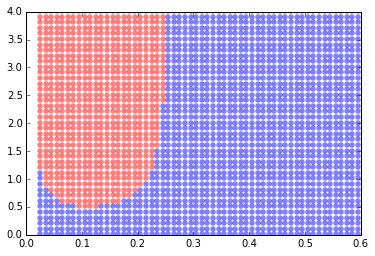

In [75]:
#plt.plot(stable[0], stable[1], 'ro')
#plt.plot(unstable[0],unstable[1], 'go')

plt.scatter(stable_n[0], stable_n[1], c="b", s=30, alpha=0.5, linewidths=0.0)
plt.scatter(unstable_n[0],unstable_n[1], c="r", s=30, alpha=0.5, linewidths=0.0)
plt.ylim((0,4))
plt.xlim((0,0.6))

In [117]:
unstable

[[], []]

In [31]:
a = array([[1, 2, 3], [4, 5, 6], [4, 2, 6]])
print a
print det(a)

[[1 2 3]
 [4 5 6]
 [4 2 6]]
-18.0


In [30]:
a = array([[1, 2, 3], [4, 5, 6], [4, 2, 6]])
(sign1, logdet1) = slogdet(a)
sign1*exp(logdet1)

-17.999999999999996

**Sizes**

In [ ]:
d_c = 1.0 #diameter of colloid
d_p = 0.33 #diameter of the polymer (~2xR_G)

**Colloid packing fraction**

In [ ]:
n_c = 0.05 #set volume fraction of the colloids

**Number of polymers and ions per colloid**

In [ ]:


p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 0.5*p_c
p_pos = 10.0*p_c
p_neg = 20.0*p_c


p = 
x_c = 
x_p = 


In [10]:
i=3 

def test_func(x):
    x = 5
    return "hi"
    
print test_func(i)

print i

hi
3


In [34]:
thingy = "pp"
if thingy in ["cc", "pp", "ss"]:
    print "hello"


hello


In [ ]:
def calculate_f_ex_int(p, x_c, x_p, #state variables
                        d_c, R_G, R_cp, BA, #system parameters
                        g_AO #reference structure
                        ):
    
    #some convenient transformations of the various inputs
    #n_c = p*x_c*(pi/6.0)*(d_c**3.0)
    #n_p = p*x_p*(4.0/3.0)*pi*(R_G**3.0)
    #z_cp = ((4.0*R_G)/d_c)/(1.0 + (2.0*R_G)/d_c)
    
    #AO adjusted contact value
    #g_AO = (1.0/(1.0-n_c-n_p)) + (g_HS - 1.0/(1.0-n_c-n_p))*z_cp
    
    #interfacial free energy contribution
    f_ex_int = -4.0*pi*p*x_c*x_p*R_cp*((d_c/2.0 + R_G)**2.0)*g_AO*(exp(BA)-1.0)
    
    return f_ex_int

In [ ]:
def calculate_C(type_1, type_2, type_3)

def calculate_B_3(type_1, type_2, type_3, d_c, R_G):
    if type_1 == "c":
        d_1 = d_c


def calculate_f_ex_ao(p, x_c, x_p, #state variables
                        d_c, R_G #system parameters
                      ):
    
    #the dimensionless 2nd and 3rd hard sphere virial coefficients in 3D
    b_2 = 4.0
    b_3 = 10.0
    
    #various c parameters used to calculate the mixture virial coefficients
    #colloid terms
    C_c_cc = (b_3/b_2)*(d_c**3.0)
    C_c_pp = (d_c + 2.0*R_G)**3.0
    C_c_cp = (d_c**3.0) + (b_3/b_2 - 1.0)*((4.0*R_G*(d_c**3.0))/(d_c + 2.0*R_G))
    #polymer_terms
    C_p_cc = ((2.0*R_G)**3.0) + (b_3/b_2 - 1.0)*d_c*((2.0*R_G)**2.0)
    C_p_pp = 0.0
    C_p_cp = 0.0
    
    #calculate the various B parameters
    
    #some convenient transformations of the various inputs
    p_c = p*x_c
    p_p = p*x_p
    X_c = p_c/(p_c + p_p)
    X_p = p_p/(p_c + p_p)
    n_c = p_c*(pi/6.0)*(d_c**3.0)
    n_p = p_p*(4.0/3.0)*pi*(R_G**3.0)
    Q = X_c*(d_c**3.0)
    
    #calculate the reference hard sphere excess free energy
    f_ex_hs = calculate_f_ex_hs((n_c + n_p))
    
    #
    f_ex_ao_lower = log(1.0 - n_c - n_p)*((b_3*Q*B_2 - b_2*B_3)/((b_3 - b_2)*(Q**2.0)))
    f_ex_ao_upper = f_ex_hs*((B_3 - Q*B_2)/((b_3 - b_2)*(Q**2.0)))

In [ ]:


p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 0.5*p_c
p_pos = 10.0*p_c
p_neg = 20.0*p_c


p = 
x_c = 
x_p = 


In [39]:
4.0 < [1.0,1.2,1.0]

True

In [91]:
nd.Hessian?

In [102]:
nd.MinStepGenerator?

In [81]:
nd.MinStepGenerator.base_step=0.00001
nd.MinStepGenerator.num_step=2

In [88]:
nd.core.MinStepGenerator.base_step=0.00001
nd.core.MinStepGenerator.num_step=2

In [87]:
print nd.MinStepGenerator.steps

AttributeError: type object 'MinStepGenerator' has no attribute 'steps'

In [104]:
hess_steps = nd.MinStepGenerator(base_step=0.00001, step_ratio=2.0)
for k in range(2):
    print hess_steps

MinStepGenerator(scale=None,use_exact_steps=True,check_num_steps=True,num_steps=None,offset=0,num_extrap=0,step_ratio=2.0,base_step=1e-05)
MinStepGenerator(scale=None,use_exact_steps=True,check_num_steps=True,num_steps=None,offset=0,num_extrap=0,step_ratio=2.0,base_step=1e-05)


In [ ]:
#################################################################################################

In [ ]:
def calculate_f_derivatives(element, Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA): 
        
    #perform calculations
    if element in ["cc", "pp", "ss"]: 
        if element == "cc":
            f_bck = calculate_f(p_c - Dp, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_cen = calculate_f(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_frd = calculate_f(p_c + Dp, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
        elif element == "pp":
            f_bck = calculate_f(p_c, p_p - Dp, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_cen = calculate_f(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_frd = calculate_f(p_c, p_p + Dp, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
        elif element == "ss":
            f_bck = calculate_f(p_c, p_p, p_s - Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_cen = calculate_f(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_frd = calculate_f(p_c, p_p, p_s + Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            
        d2f_pure = (f_bck - 2.0*f_cen + f_frd) / (Dp**2.0)
        return d2f_pure
    
    elif element in ["cp", "cs", "ps"]:
        if element == "cp":
            f_frd_frd = calculate_f(p_c + Dp, p_p + Dp, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_frd_bck = calculate_f(p_c + Dp, p_p - Dp, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_bck_frd = calculate_f(p_c - Dp, p_p + Dp, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_bck_bck = calculate_f(p_c - Dp, p_p - Dp, p_s, d_c, d_p, l, Z_c, R_cp, BA, "V")
        elif element == "cs":
            f_frd_frd = calculate_f(p_c + Dp, p_p, p_s + Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_frd_bck = calculate_f(p_c + Dp, p_p, p_s - Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_bck_frd = calculate_f(p_c - Dp, p_p, p_s + Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_bck_bck = calculate_f(p_c - Dp, p_p, p_s - Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
        elif element == "ps":
            f_frd_frd = calculate_f(p_c, p_p + Dp, p_s + Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_frd_bck = calculate_f(p_c, p_p + Dp, p_s - Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_bck_frd = calculate_f(p_c, p_p - Dp, p_s + Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            f_bck_bck = calculate_f(p_c, p_p - Dp, p_s - Dp, d_c, d_p, l, Z_c, R_cp, BA, "V")
            
        d2f_mixed = (f_frd_frd - f_frd_bck - f_bck_frd + f_bck_bck) / (4.0*(Dp**2.0))
        return d2f_mixed
    
    else:
        raise ValueError('Stability matrix element type not found')    

In [ ]:
def calculate_stability_determinant(Dp, p_c, p_p, p_s, #state variables
                                    d_c, d_p, #particle sizes
                                    l, Z_c, #ionic solution parameters 
                                    R_cp, BA #interfacial attraction parameters
                                   ):
    
    #check to make sure the numerical derivative is defined
    if((Dp < p_c) and (Dp < p_p) and (Dp < p_s)):
    
        #the six double derivatives (3 same and 3 mixed)
            #same
        d2f_cc = calculate_f_derivatives("cc", Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA)
        d2f_pp = calculate_f_derivatives("pp", Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA)
        d2f_ss = calculate_f_derivatives("ss", Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA)
            #mixed
        d2f_cp = calculate_f_derivatives("cp", Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA)
        d2f_cs = calculate_f_derivatives("cs", Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA)
        d2f_ps = calculate_f_derivatives("ps", Dp, p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA)
            #using symmetry
        d2f_pc = d2f_cp
        d2f_sc = d2f_cs
        d2f_sp = d2f_ps
    
        #build the 3x3 stability matrix as a numpy array and calculate the determinant 
        #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
        stability_matrix = array([[d2f_cc, d2f_cp, d2f_cs], [d2f_pc, d2f_pp, d2f_ps], [d2f_sc, d2f_sp, d2f_ss]])
        (sign, logdet) = slogdet(stability_matrix)
        stability_determinant = sign*exp(logdet)
        
        #return the stability determinant
        return (stability_matrix, stability_determinant)
        #return (stability_matrix, det(stability_matrix))
    
    #if the derivative is not defined the return a characteristic number for easy identification
    else:
        return 12345678910

In [61]:
(-8.0)**(1./3)

ValueError: negative number cannot be raised to a fractional power

In [ ]:
######################################################################

In [45]:
def calculate_f_ex_ao_pure(p_c, p_p, #state variables
                        d_c, d_p #system parameters
                      ):
    
    vol = (d_c/2.0 + d_p/2.0)**3.0
    
    #calculate the needed densities
    p = p_c + p_p
    x_c = p_c/p
    x_p = p_p/p
    R_G = d_p/2.0
    
    #the effective volume fraction for use in the carnahan starling free energy
    n_eff = (pi/6.0)*(p_c/(p_c + p_p))*(p_c*(d_c**3.0) + p_p*((d_c/2.0 + R_G)**3.0))
    
    #modified carnahan starling free energy
    f_ex_ao = x_c*log(x_c) + x_p*log(x_p) + log(p*vol) - 1.0 + (-3.0 + 2.0/(1.0 - n_eff) + 1.0/((1.0 - n_eff)**2.0))
    
    return (p*f_ex_ao)

In [25]:
def calculate_f_ex_ao_fv(p_c, p_p, #state variables
                        d_c, d_p #system parameters
                      ):
    
    vol = (d_c/2.0 + d_p/2.0)**3.0
    
    #calculate the needed densities
    n_c = (pi/6.0)*(d_c**3.0)*p_c
    
    #ratio
    q = d_p/d_c
    
    #some params
    A = 3.0*q + 3.0*(q**2.0) + q**3.0
    B = (9.0/2.0)*(q**2.0) + 3.0*(q**3.0)
    C = 3.0*(q**3.0)
    
    #modified carnahan starling free energy
    f_hs_ex = p_c*(-3.0 + 2.0/(1.0 - n_c) + 1.0/((1.0 - n_c)**2.0))
    f_hs = p_c*log(p_c) - p_c + f_hs_ex
    f_ao_id = p_p*log(p_p) - p_p
    w = -log(1.0 - n_c) + A*(n_c/(1.0 - n_c)) + B*((n_c/(1.0 - n_c))**2.0) + C*((n_c/(1.0 - n_c))**3.0) 
    f_ex_ao = p_p*w
    
    f_ao = f_hs + f_ao_id + f_ex_ao
    
    return f_ao

In [99]:
def calculate_stability_determinant_ao_pure(p_c, p_p, #state variables
                                            d_c, d_p, #particle sizes
                                            min_step #minimum step to use for hessian calculation
                                           ):
    
    #calculate the hessian matrix
    hess_steps = nd.MinStepGenerator(base_step=min_step, step_ratio=2.0, num_steps = 3)
    calculate_hessian = lambda x: calculate_f_ex_ao_fv(x[0], x[1], d_c, d_p)
    stability_matrix = nd.Hessian(calculate_hessian, step = hess_steps)([p_c, p_p])
    
    #build the 3x3 stability matrix as a numpy array and calculate the determinant 
    #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
    (sign, logdet) = slogdet(stability_matrix)
    #stability_determinant = sign*exp(logdet)
    #stability_determinant = sign*(exp(logdet)**(1.0/3.0))
    stability_determinant = det(stability_matrix)
        
    #return the stability determinant
    return (stability_matrix, stability_determinant)
    #return (stability_matrix, det(stability_matrix))

In [101]:
d_c = 1.0 #1.0
d_p = 0.3 #0.3

n_c = 0.5
n_p = 0.045

p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 6.0*n_p/(pi*d_p*d_p*d_p)

min_step= 0.001

print (pi/6.0)*p_p*(d_p**3.0)

print calculate_stability_determinant_ao_pure(p_c, p_p, d_c, d_p, min_step)


0.045
(array([[ 117.21631256,    6.09887854],
       [   6.09887854,    0.31415926]]), -0.37172883369891219)


In [103]:
d_c = 1.0 #1.0
d_p = 0.3 #0.3

n_c = 0.025

t_1 = 1.0 - n_c
t_2 = 1.0 + 2.0*n_c
q = d_p/d_c

n_p_s = (((t_1**4.0)*t_2)/n_c)/(12.0*(t_1**3.0) + 15.0*q*(t_1**2.0)*t_2 + 6.0*(q**2.0)*t_1*(t_2**2.0) + (q**3.0)*(t_2**3.0))
print n_p_s
print 6.0*n_p_s/(pi*d_p*d_p*d_p)
print 6.0*n_c/(pi*d_c*d_c*d_c)
print (6.0*n_p_s/(pi*d_p*d_p*d_p)) / (6.0*n_c/(pi*d_c*d_c*d_c))

2.33917816195
165.463007665
0.0477464829276
3465.44912881


In [ ]:
    a = stability_matrix[0][0]
    b = stability_matrix[0][1]
    c = stability_matrix[0][2]
    d = stability_matrix[1][1]
    e = stability_matrix[1][2]
    f = stability_matrix[2][2]
    
    stability_determinant = a*(d*f - e*e) + b*(c*e - b*f) + c*(b*e - d*c)

In [ ]:
#takes as input the desired volume fraction and the gr data in dataframe format
#and linearly interpolates between the two nearest stored volume fractions
def calculate_rdf(eta, d):
    global rdf_current #need to make this global since we need to modify it
    rdf = pd.DataFrame()
    
    if eta in rdf_current.columns: #use the stored version so as to not compute it more than needed
        rdf["gr"] = rdf_current[eta]
        rdf["r"] = d*rdf_data["r"]
        return rdf
    else: #empty out the stored rdf and generate a new one
        rdf_current = pd.DataFrame()
        eta_inc = rdf_data.columns[1] #store the eta increment
        eta_max = rdf_data.columns[-2] #store the maximum eta to check if overstepped
        upper_index = int(eta / eta_inc) + 1 #for storing the nearest low and high volume fractions
        lower_index = int(eta / eta_inc)
        if eta >= eta_max:
            print "error: eta is too large to calculate!"
            return rdf
        try:
            eta_upper = rdf_data.columns[upper_index] #grab the lower and upper packing fractions for interpolation
            eta_lower = rdf_data.columns[lower_index]
        except:
            print "error: something went wrong with rdf calculation!"
            return rdf
        #create the interpolated rdf
        rdf["gr"] = ((eta_upper - eta)/(eta_upper - eta_lower))*rdf_data[eta_lower] + ((eta - eta_lower)/(eta_upper - eta_lower))*rdf_data[eta_upper]
        rdf["r"] = d*rdf_data["r"]
        rdf_current[eta] = rdf["gr"][:]
        return rdf

###RETIRED FUNCTIONS STORED HERE

###Calculate the effective volume fraction factor according to Hamad's theory to get effective RDF to be used for the two perturbative free energy terms

---

In [ ]:
#evaluate the volume fraction factor for calculating the colloid-colloid AO RDF
def calculate_n_scale(components, p_c, p_p, #state variables  
                   d_c, d_p #system parameters
                  ):
    
    #set the needed parameters to compute the scale parameter
    b_2 = 4.0
    b_3 = 10.0
    Q = p_c*(d_c**3.0)
    
    #detect if for colloid-colloid or colloid-polymer
    #note: the x_c and x_p used should technically should sum to unity
    #but it does not matter due to the division step (see Santos paper for definitions)
    if components == "cc":
        C_c_cc = (b_3/b_2)*(d_c**3.0)
        C_p_cc = (d_p**3.0) + (b_3/b_2 - 1.0)*d_c*(d_p**2.0)
        w_cc = (b_2/b_3)*(p_c*C_c_cc + p_p*C_p_cc)/Q
        return w_cc
    elif components == "cp":
        C_c_cp = (d_c**3.0) + (b_3/b_2 - 1.0)*((2.0*d_p*(d_c**3.0))/(d_c + d_p))
        C_p_cp = 0.0
        w_cp = (b_2/b_3)*(p_c*C_c_cp + p_p*C_p_cp)/Q
        return w_cp
    
    #return a zero if no coded type used
    return 0

**Checking for scale invariance DLVO**

In [ ]:
d_c = 1.0
d_p = 0.30
l = 0.1 
Z_c = 100.0

n_c = 0.025

p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 0.5*p_c
p_pos = 10.0*p_c
p_neg = 20.0*p_c
p = p_c + p_p + p_pos + p_neg

#(OLD VALUES FOR 1/N f CALC)
#p = p_c + p_p + p_pos + p_neg
#x_c = p_c/p
#x_p = p_p/p
#x_pos = p_pos/p
#x_neg = p_neg/p

#calculate the free energy contribution
calculate_f_ex_dlvo(p_c, p_pos, p_neg, l, Z_c, d_c, d_p)/p #(NEED 1/p TO COMPARE TO OLD VALUES)
#-17.67148544525654 (OLD VALUE WITH NO PERT)
#-18.025917790970816 (OLD VALUE WITH PERT)

**Checking for scale invariance INT**

In [ ]:
d_c = 1.0 #1.0
d_p = 0.30 #0.3
R_cp = 0.01 #0.05
BA = 13.0

n_c = 0.025

p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 0.5*p_c
p_pos = 10.0*p_c
p_neg = 20.0*p_c

p = p_c + p_p + p_pos + p_neg
x_c = p_c/p
x_p = p_p/p
x_pos = p_pos/p
x_neg = p_neg/p


calculate_f_ex_int(p_c, p_p, d_c, d_p, R_cp, BA)/p

#-18.577585661644907 (OLD VALUE)

**Checking for scale invariance AO**

In [ ]:
d_c = 5.0 #1.0
d_p = 1.5 #0.3

n_c = 0.4
n_p = 0.108

p_c = 6.0*n_c/(pi*d_c*d_c*d_c)
p_p = 6.0*n_p/(pi*d_p*d_p*d_p)

calculate_f_ex_ao(p_c, p_p, #state variables
                      d_c, d_p #system parameters
                      )/(p_c + p_p)

#1.6908515771610024